In [1]:
import pickle

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers, optimizers, metrics, losses, utils
from tensorflow.keras import applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt

In [2]:
!pip install -q git+https://github.com/EfficientDL/codelab_utils.git

import matplotlib.pyplot as plt
import codelab_utils.mpl_styles as mpl_styles

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

In [3]:
# Load Oxford-IIIT Pet Dataset
train_ds, val_ds, test_ds = tfds.load(
    'oxford_iiit_pet:3.*.*',
    split=['train[:80%]', 'train[80%:]', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

2022-07-08 02:58:22.877566: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-train.tfrecord...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-test.tfrecord...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


2022-07-08 02:59:56.491344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 02:59:56.621024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 02:59:56.621879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 02:59:56.624236: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
IMG_SIZE = 128

def preprocess(item):
    image, mask = item['image'], item['segmentation_mask']

    # Resize image and mask to IMG_SIZE
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])

    # Normalize the image and realign the mask.
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    
    return image, mask

train_prep_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_prep_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_prep_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

2022-07-08 02:59:59.736986: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


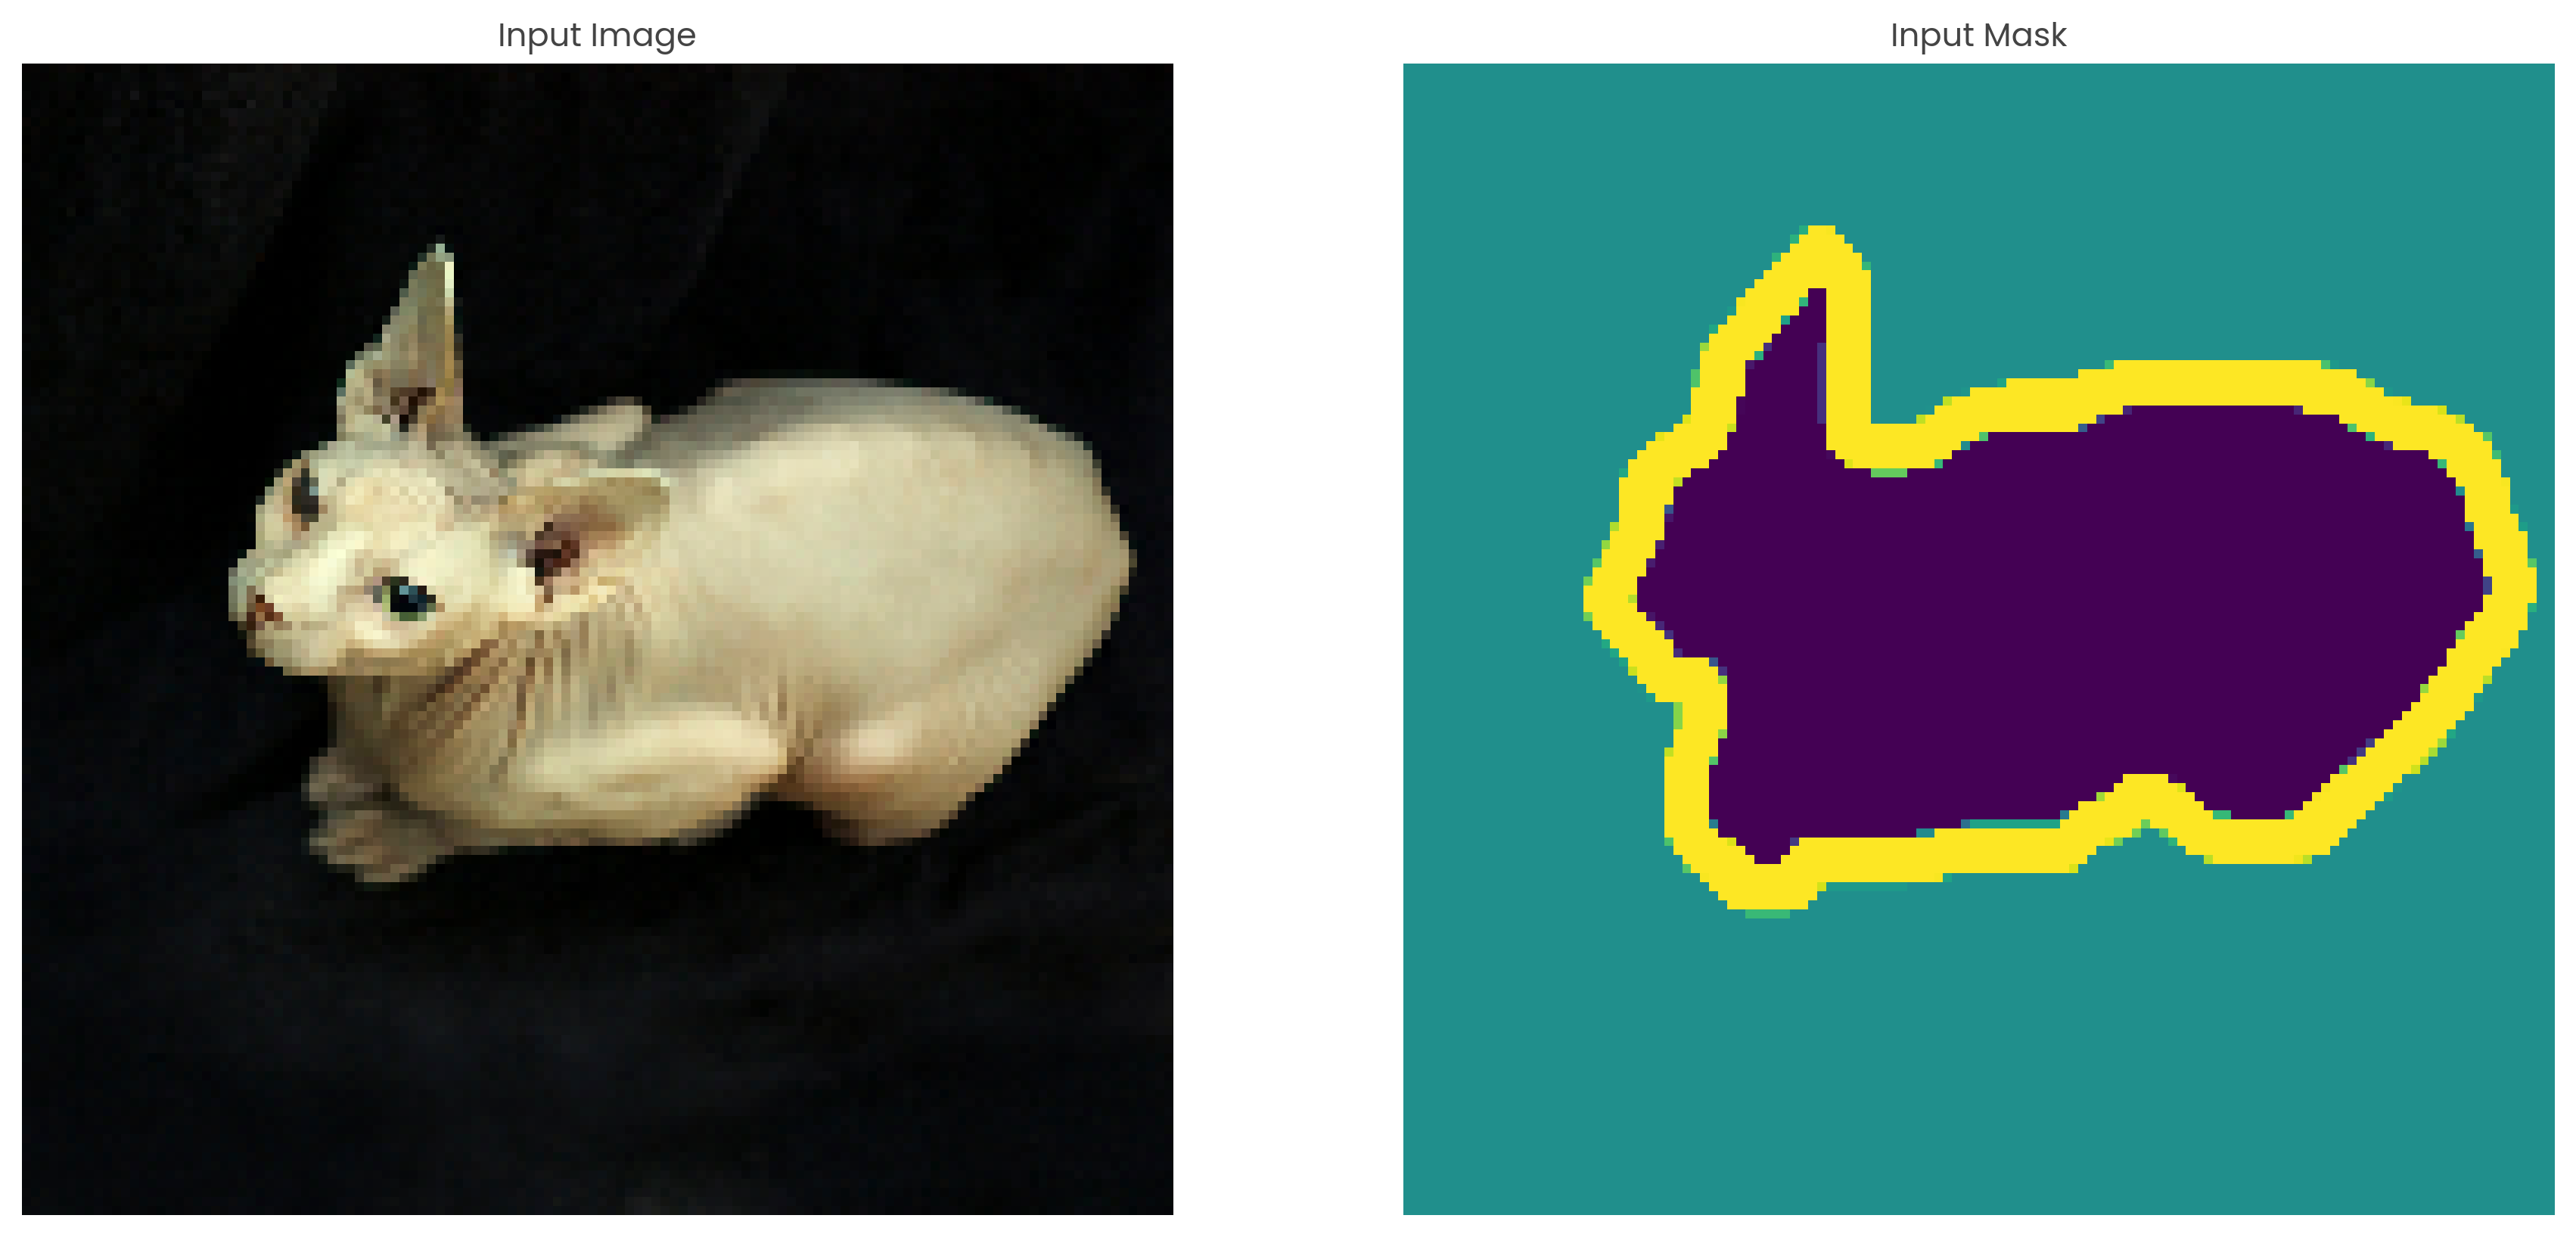

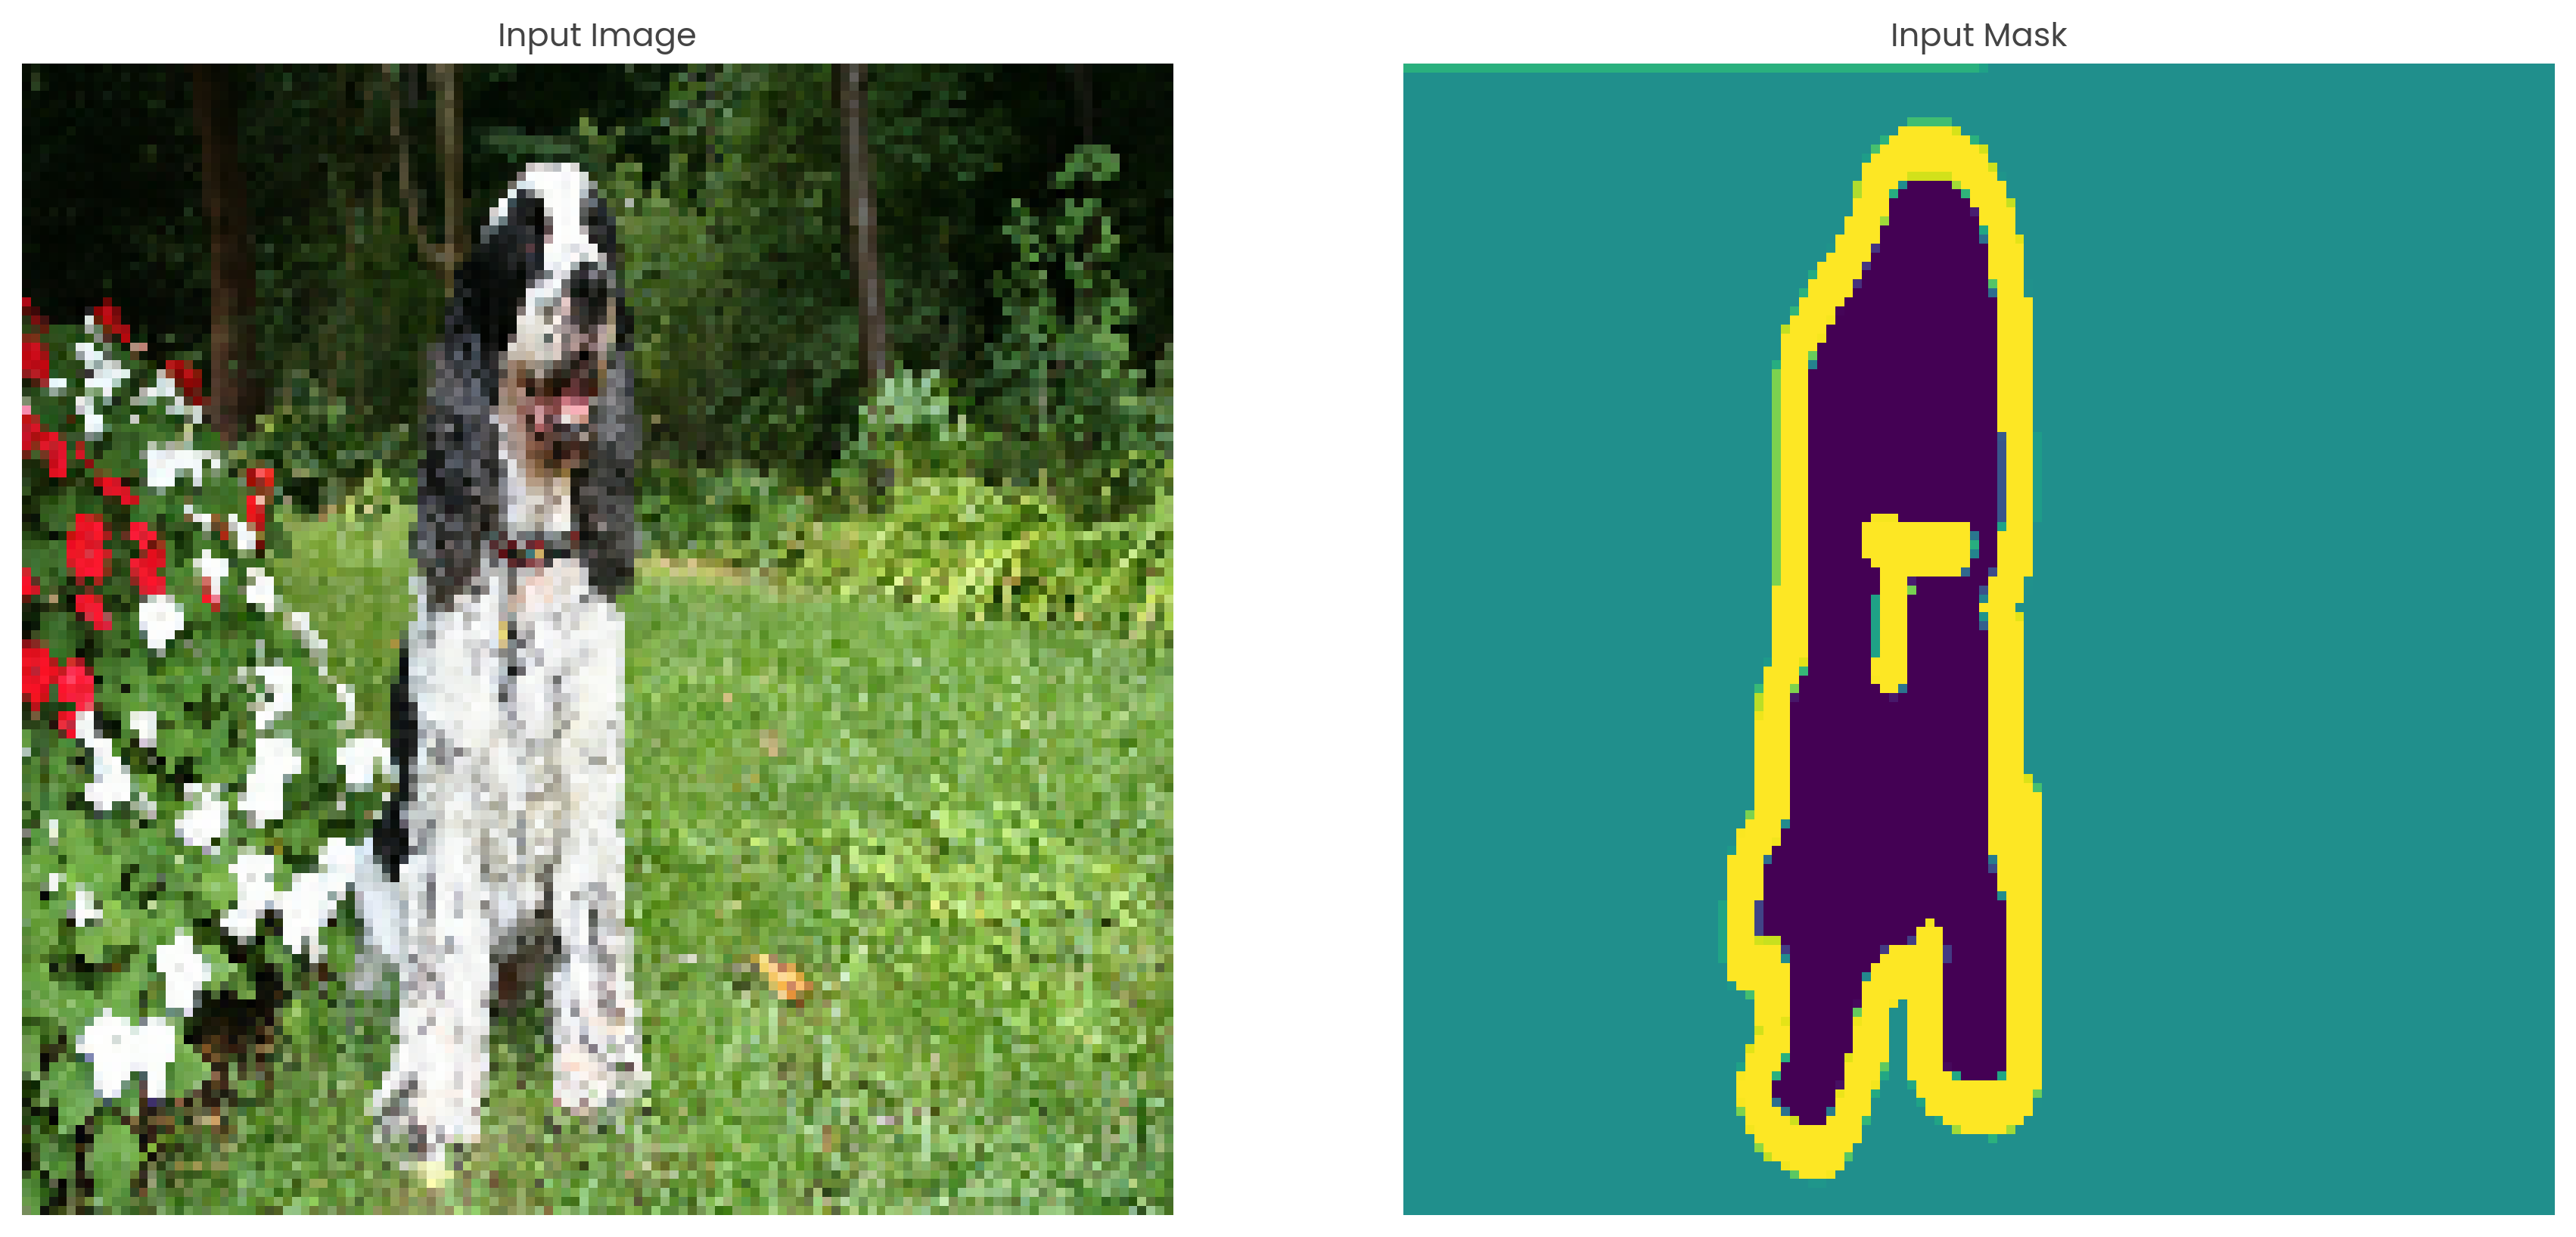

In [5]:
def display(display_list, title=['Input Image', 'Input Mask', 'Predicted Mask']):
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train_prep_ds.take(2):
    display([image, mask])

In [6]:
LEARNING_RATE = 0.001
N_CLASSES = 3

layer_id = -1
def get_layer_id():
    global layer_id
    layer_id += 1
    
    return str(layer_id)
    
def get_conv_block(filters, strides):
    return tf.keras.Sequential(
        [
            layers.Conv2D(filters, 3, padding='same', strides=strides),
            layers.BatchNormalization(),
            layers.ReLU(),
        ],
        name='conv_block_' + get_layer_id()
    )

def get_dsc_block(filters, strides):
    return tf.keras.Sequential(
        [
            layers.DepthwiseConv2D(3, padding='same', strides=strides),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, 1, padding='same', strides=1),
            layers.BatchNormalization(),
            layers.ReLU(),
        ],
        name='dsc_block_' + get_layer_id()
    )

def get_conv_transpose_block(filters):
    initializer = tf.random_normal_initializer(0., 0.02)
    kwargs = dict(strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
    
    return tf.keras.Sequential(
        [
            layers.Conv2DTranspose(filters, 3, **kwargs),
            layers.BatchNormalization(),
            layers.ReLU()
        ],
        name='conv_transpose_block_' + get_layer_id()
    )

def get_conv_builder(block_type='conv'):
    if (block_type == 'conv'):
        return get_conv_block
    elif (block_type == 'dsc'):
        return get_dsc_block
    else:
        raise ValueError('Invalid block type: ', block_type)

def create_model(conv_type='conv'):
    builder = get_conv_builder(conv_type)
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        get_conv_block(32, strides=2),
        builder(64, strides=1),
        builder(128, strides=2),
        builder(128, strides=1),
        builder(256, strides=2),
        builder(256, strides=1),
        builder(512, strides=2),
        builder(512, strides=1),
        builder(512, strides=1),
        builder(512, strides=1),
        builder(512, strides=1),
        builder(512, strides=1),
        builder(1024, strides=2),
        get_conv_transpose_block(512),
        get_conv_transpose_block(256),
        get_conv_transpose_block(128),
        get_conv_transpose_block(64),
        get_conv_transpose_block(3),
    ])
    
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
    
    return model

model = create_model(conv_type='dsc')
# model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block_0 (Sequential)    (None, 64, 64, 32)        1024      
_________________________________________________________________
dsc_block_1 (Sequential)     (None, 64, 64, 64)        2816      
_________________________________________________________________
dsc_block_2 (Sequential)     (None, 32, 32, 128)       9728      
_________________________________________________________________
dsc_block_3 (Sequential)     (None, 32, 32, 128)       18816     
_________________________________________________________________
dsc_block_4 (Sequential)     (None, 16, 16, 256)       35840     
_________________________________________________________________
dsc_block_5 (Sequential)     (None, 16, 16, 256)       70400     
_________________________________________________________________
dsc_block_6 (Sequential)     (None, 8, 8, 512)         1

In [7]:
def train(model, tds, vds, epochs=100, callbacks=[]):
    tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE)
    vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE) if vds else None
#     tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE).take(1)
#     vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE).take(1) if vds else None
    history = model.fit(tds, validation_data=vds, epochs=epochs, callbacks=callbacks)

    return history

In [8]:
checkpoint_name_tmpl = 'dsc_conv/weights-epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}.h5'
checkpoint = cbs.ModelCheckpoint(checkpoint_name_tmpl, save_best_only=True, monitor="val_accuracy")

# EPOCHS = 1
EPOCHS = 50
BATCH_SIZE = 16

callbacks = [checkpoint]
tds = train_prep_ds.cache().shuffle(1000, reshuffle_each_iteration=True).batch(BATCH_SIZE)
vds = val_prep_ds.batch(256).cache()

hist = train(model, tds, vds, epochs=EPOCHS, callbacks=callbacks)

with open('training.results.pkl', 'wb') as f:
    pickle.dump(hist.history, f)

Epoch 1/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2022-07-08 03:00:09.129255: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


184/184 [==============================] - 26s 73ms/step - loss: 0.8645 - accuracy: 0.5844 - val_loss: 0.9694 - val_accuracy: 0.5323
Epoch 2/50
184/184 [==============================] - 8s 43ms/step - loss: 0.7956 - accuracy: 0.6126 - val_loss: 0.9137 - val_accuracy: 0.5755
Epoch 3/50
184/184 [==============================] - 8s 44ms/step - loss: 0.7485 - accuracy: 0.6297 - val_loss: 0.9164 - val_accuracy: 0.5484
Epoch 4/50
184/184 [==============================] - 8s 43ms/step - loss: 0.7042 - accuracy: 0.6451 - val_loss: 0.7007 - val_accuracy: 0.6420
Epoch 5/50
184/184 [==============================] - 8s 43ms/step - loss: 0.6688 - accuracy: 0.6567 - val_loss: 0.7402 - val_accuracy: 0.6329
Epoch 6/50
184/184 [==============================] - 8s 43ms/step - loss: 0.6447 - accuracy: 0.6639 - val_loss: 0.7018 - val_accuracy: 0.6483
Epoch 7/50
184/184 [==============================] - 8s 44ms/step - loss: 0.6151 - accuracy: 0.6733 - val_loss: 0.7533 - val_accuracy: 0.6308
Epoch 8/5

{'loss': [0.8645002841949463,
  0.7956200242042542,
  0.7485305070877075,
  0.7042443752288818,
  0.668755054473877,
  0.6447104811668396,
  0.6151143312454224,
  0.6044332981109619,
  0.5760966539382935,
  0.5589994192123413,
  0.5362657308578491,
  0.5102653503417969,
  0.4991287291049957,
  0.48988577723503113,
  0.47971969842910767,
  0.47366321086883545,
  0.45511487126350403,
  0.4387804865837097,
  0.4288172423839569,
  0.42639216780662537,
  0.4211496412754059,
  0.40942999720573425,
  0.3949924111366272,
  0.3869742155075073,
  0.3785531520843506,
  0.3730950653553009,
  0.3777119219303131,
  0.38022929430007935,
  0.37725353240966797,
  0.3625718951225281,
  0.3215782940387726,
  0.20668508112430573,
  0.20515182614326477,
  0.19323310256004333,
  0.18254651129245758,
  0.17368373274803162,
  0.16649244725704193,
  0.1734396070241928,
  0.19976100325584412,
  0.1974383294582367,
  0.2034490555524826,
  0.1770651638507843,
  0.16071166098117828,
  0.14667196571826935,
  0.1387

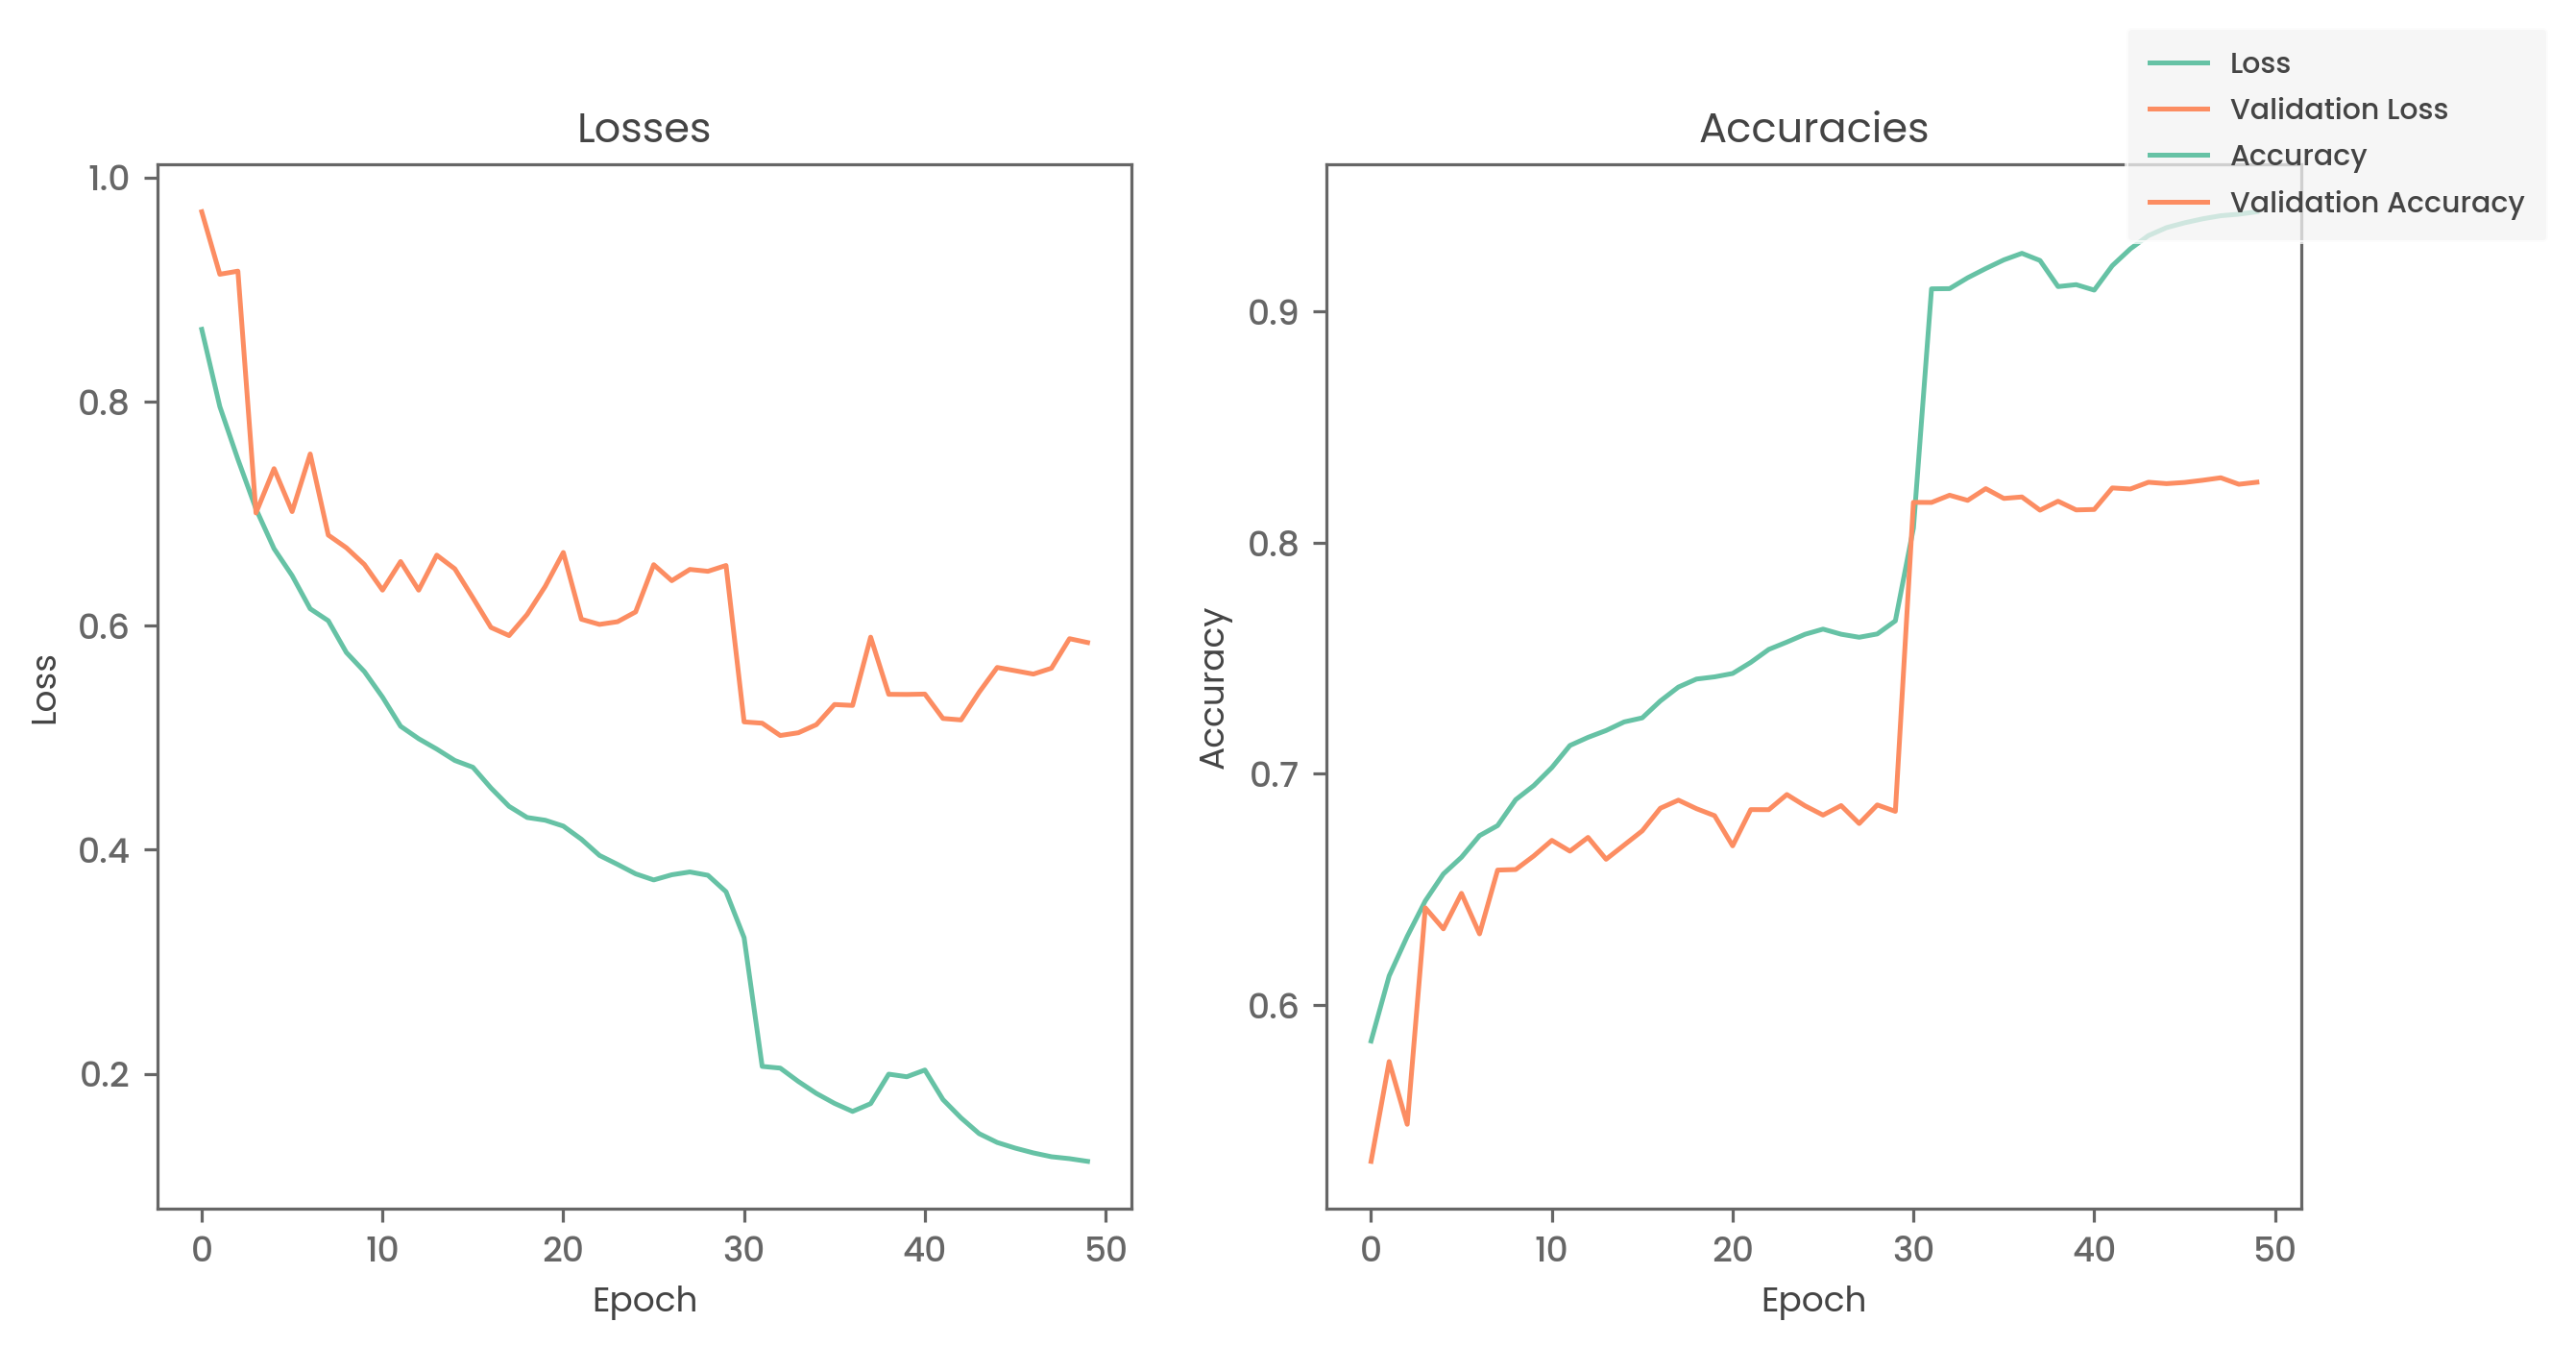

In [9]:
def plot_history(h):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), facecolor='w', edgecolor='k')

    axes[0].plot(h['loss'], label='Loss')
    axes[0].plot(h['val_loss'], label='Validation Loss')

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Losses')

    axes[1].plot(h['accuracy'], label='Accuracy')
    axes[1].plot(h['val_accuracy'], label='Validation Accuracy')

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracies')

    fig.legend()

plot_history(hist.history)
hist.history

In [10]:
model.evaluate(test_prep_ds.batch(256))

15/15 [==============================] - 9s 564ms/step - loss: 0.6145 - accuracy: 0.8227


[0.6145180463790894, 0.822651207447052]